In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame = False)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

Saving figure some_digit_plot


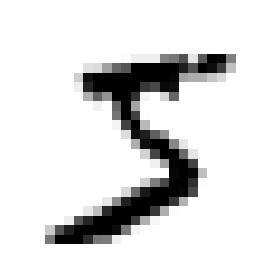

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


some_digit = X[0]

def plot_digit(some_digit):
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.axis("off")
   
plot_digit(some_digit)
save_fig("some_digit_plot")
plt.show()


In [6]:
y = y.astype(np.uint8)

Split the set, this set is already split into the training set (the first 60,000 images) and the test set (the last 10,000 images). The training set is already shuffled. 

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Cross-validation

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Accuracy is not the preferred performance measure for classifiers. In this case it has over 90% accuracy because only about 10% of the images are 5's, so if we had a classifier that its result is always "false" it would still have over 90% of accuracy.

### Confusion matrix

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

cross_val_predict() performs K-fold cross-validation and returns the predictions made on each test fold.

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [14]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off

The higher the precision, the lower the recall, and viceversa.

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

In [18]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([False])

To decide which threshold to use, do the following:

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

precision_recall_curve() compute precision and recall for all possible thresholds

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g", label="Recall")
    plt.legend(loc="center right")
    plt.xlabel('Thresholds')
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

90% precision classifier

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_score(y_train_5, y_train_pred_90)

### The ROC curve

The ROC curve plots the true positive rate (recall or sensitivity) against the false positive rate (1 - specifity ).

The higher the recall, the more false positives the classifier produces.

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--', label = "Random Classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    plt.grid(True)
    
plot_roc_curve(fpr, tpr, "My classifier")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:,1] #score = probability that the given instance represents a 5. Proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [ ]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

#### Precision and recall for Random Forest Classifier

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

## Multiclass Classification

-Support vector Machine classifier (binary classifier) for multiclass classification. Sickit-learn detects when you use a binary classification algorithm por a multiclass classification, and it automatically runs OvR or OvO. 

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_

OneVsRestClassifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

SGD Classifier. This can directly classify instances into multiple classes.

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

Scalling inputs

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

## Error Analysis

Confusion matrix

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show

Error rate: this is computed dividing each value in the confusion matrix by the number of images in the corresponding class.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Many images get misclassified as 8s, strategies that you can try to reduce the false 8s:
    -Try to gather more training data for digits that look like 8 but are not.
    -Add new features to help the classifier (number of closed loops, 8 has two).
    -Preprocess the images to make some patterns stand out more.
    

Analyzing individual errors

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
        
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_aa[:25], images_per_row=5)

plt.show()

One way to reduce the 3/5 confusion would be to preprocess the images to ensure that are weel centered and not too rotated so the SGDClassifier can assign a different weight to 3 and 5.

## Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

Evaluating multilabel classifier

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## Multioutput Classification

In [ ]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 5
plot_digit(X_test_mod[some_index])

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Exercises

### 1
Try  to  build  a  classifier  for  the  MNIST  dataset  that  achieves  over  97%  accuracy on  the  test  set

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_params = {'n_neighbors': [3,5,11,19], 'weights':['uniform', 'distance'], 'metric':['euclidean', 'manhattan']}

grid_search = GridSearchCV(knn_clf, grid_params, verbose = 1, cv = 3, n_jobs = -1)

results = grid_search.fit(X_train_scaled, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

### 2
Write a function that can shift an MNIST image in any direction (left, right, up,or down) by one pixel

In [ ]:
from scipy.ndimage.interpolation import shift

def shift_image(digit, shift):
    digit_image = digit.reshape(28, 28)
    return shift(digit_image, shift, cval = 0)
    

Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set

In [ ]:
new_X_train = [image for image in X_train]
new_y_train = [label for label in y_train]


for direction in [[0, -2], [-2, 0], [0, 2], [2, 0]]:
    for image, label in zip(new_X_train, new_y_train):
        new_X_train.append(image, direction)
        new_y_train.append(label, direction)
        
    
new_X_train = np.array(new_X_train)
new_y_train = np.array(new_y_train)
    

Finally, train your best model on this expanded training set and measure its accuracy on the test set.

In [ ]:
#Grid search with best params

### 3
Tackle the Titanic dataset.

1. https://www.kaggle.com/aralmata/getting-started-with-titanic
2. https://www.kaggle.com/aralmata/titanic-competition    

### 4
Build a spam classifier

1. https://www.kaggle.com/aralmata/spam-classifier